### NAIVE BAYES FROM SCRATCH WITH MUTUAL INFORMATION (MI) BASED FEATURE SELECTION

### IMPORTING REQUIRED MODULES

In [3]:
import re
from nltk import word_tokenize
import glob  
from nltk.corpus import stopwords
import time
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
import os
import sys 
from tqdm import tqdm
import pickle
from collections import Counter
import operator
import math
import json
import numpy as np
import pandas as  pd
from prettytable import PrettyTable
import math
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from statistics import mode
from sklearn.metrics import confusion_matrix
import itertools
import copy
from IPython.display import display

### DATA PRE-PROCESSING FUNCTION

In [311]:
def preprocess(data):
    stopword=""
    cleantext = " "
    stopword = set(stopwords.words('english'))
    for i in word_tokenize(data):
        i=i.lower()
        if i not in stopword and len(i)>2 and not(any(l.isdigit() for l in i)):
            pattern1 = '[!.?$\[\]/\}#=<>"\*:,|_~;()^\']'
            pattern2 = '[\n\n]+'
            pattern3 = '[\ \ ]+'
            wout_sc = re.sub(pattern1,'',i) #removing special characters
            wout_el = re.sub(pattern2,'\n',wout_sc) # removing empty lines (which are greater than 2)
            wout_mspaces = re.sub(pattern3,' ',wout_el) # removing multiple spaces
            cleaned_text = wout_mspaces.strip()
            cleaned_text=lemmatizer.lemmatize(cleaned_text)
            cleantext = cleantext+cleaned_text+" "
    return cleantext.strip()

In [312]:
def read_names(path):
    i=0
    df = pd.DataFrame(columns=['Doc_Name'])
    folders = glob.glob(path)
    for f in tqdm(folders,leave=True,position=0):
        head,tail = os.path.split(f)
        if(tail=="comp.graphics"or tail=="sci.med"or tail=="talk.politics.misc"or tail=="rec.sport.hockey"or tail=="sci.space"):
            for file in glob.glob(f+"\*"):
                head1,tail1 = os.path.split(file)
                df.loc[i] = tail+"_"+tail1
                i=i+1
    return df

### TRAIN-TEST SPLIT (DECISION MAKING FOR A DOC TO BE TRAIN OR TEST)

In [313]:
def split(ratio,data_frame):
    data_frame_temp = data_frame.copy()
    train_files,test_files = train_test_split(data_frame_temp,train_size=ratio,random_state=0)
    return train_files,test_files

### READING THE DATA, BUILDING TFs and DFs & BUILDING TF-IDFs FOR TRAINING SET 
### (WE CALCULATE TF IN THE CLASS AND DF ACROSS THE CLASSES)
### CORPUS CONSIDERED :: "20 news groups"
### FOLDERS CONSIDERED:
### 1. comp.graphics
### 2. sci.med
### 3.talk.politics.misc
### 4.rec.sport.hockey
### 5.sci.space

In [314]:
def readfiles(path,ratio,test_files):
    folders = glob.glob(path)
    preproc_data_dict={} ## key : file-name, value: pre-processed data
    vocab={}
    files_read=0
    preproc_data_filewise={} ## only for training data files
    train_files_class_wise={}
    test_preproc_dict={}
    doc_counts_classwise={}
    tfs_class_wise={}
    for f in tqdm(folders,leave=True,position=0):
        head,tail = os.path.split(f)
        if(tail=="comp.graphics"or tail=="sci.med"or tail=="talk.politics.misc"or tail=="rec.sport.hockey"or tail=="sci.space"):
            for file in glob.glob(f+"\*"):
                flag=0
                head1,tail1 = os.path.split(file)
                with open(file) as newlinetest:   ## identifying the first new line in the data.. to remove meta-data
                    indi = newlinetest.readlines()
                for newline in range(len(indi)):
                    if(indi[newline]!="\n"):
                        continue
                    break
                filedata=[]
                try:
                    with open(file,"r") as data:  ## READING THE DATA ignoring the meta-data
                        filedata.append(data.readlines()[newline+1:])
                        for l in range(len(filedata)):
                            inter_data = ' '.join(filedata[l])
                    preproc_data = preprocess(inter_data)
                    if(tail+"_"+tail1 not in list(test_files['Doc_Name'])): ## reading only the training data
                        files_read+=1
                        if tail not in train_files_class_wise:
                            train_files_class_wise[tail]=1
                        else:
                            train_files_class_wise[tail]+=1
                        preproc_data_filewise[tail+"_"+tail1] = preproc_data
                        if tail not in preproc_data_dict: ## merging the data of all documents belonging to a single class..
                            preproc_data_dict[tail] = preproc_data
                        else:
                            preproc_data_dict[tail] = preproc_data_dict[tail]+" "+preproc_data
                    else:
                        test_preproc_dict[tail+"_"+tail1] = preproc_data
                    
                except :
                    print("EXCEPTION OCCURED..")
    for cls in preproc_data_dict: ## generating vocab w.r.t training data
        for w in preproc_data_dict[cls].split():
            if w not in vocab:
                vocab[w]=1
            else:
                vocab[w]+=1
    #print("VOCAB::",vocab)
    print("\n====> GENERATING TFs...\n")
    for d in tqdm(preproc_data_dict,leave=True,position=0): ## computing term-frequencies....
        tf_dict={}
        for w in preproc_data_dict[d].split():
            if w not in tf_dict:
                tf_dict[w]=1
            else:
                tf_dict[w]+=1
        tfs_class_wise[d] = tf_dict
    print("TOTAL TRAINING FILES READ::",files_read)
    print("LENGTH OF THE VOCABULARY::",len(vocab))
    classes = list(train_files_class_wise.keys())
    classes.sort() ## sorting to maintain a uniform order throught...
    for i in classes:
        doc_counts_classwise[i]=0
    df = pd.DataFrame(columns=["↓ term ; class ->"]+classes)
    df_row_count=0
    print("\n====> GENERATING/LOADING TABLE FOR MUTUAL INFORMATION CALCULATIONS...\n")
    #for word in tqdm(vocab,leave=True,position=0): ## code to generate MI table (in comments since mi tables are pickled...)
    #    counts=[]
    #    counts.append(word) #preproc_data_filewise
    #    for file in preproc_data_filewise:
    #        class_ = file.split("_")[0]
    #        if word in preproc_data_filewise[file].split():
    #            doc_counts_classwise[class_]+=1
    #    doc_counts_classwise = dict(sorted(doc_counts_classwise.items()))
    #    for i in doc_counts_classwise:
    #        counts.append(doc_counts_classwise[i])
    #        doc_counts_classwise[i]=0
    #    df.loc[df_row_count] = counts
    #    df_row_count=df_row_count+1
        
    ###LOADING THE DATAFRAMES OF MUTUAL INFORMATION TABLE FOR A PARTICULAR SPLIT...
    if(ratio==0.50):
        pickle_in = open("mi_table_5050","rb")
        df = pickle.load(pickle_in)
        print("MI TABLE CORRESPONDING TO 50:50 SPLIT LOADED...!!!")
    if(ratio==0.70):
        pickle_in = open("mi_table_7030","rb")
        df = pickle.load(pickle_in)
        print("MI TABLE CORRESPONDING TO 70:30 SPLIT LOADED...!!!")
    if(ratio==0.80):
        pickle_in = open("mi_table_8020","rb")
        df = pickle.load(pickle_in)
        print("MI TABLE CORRESPONDING TO 80:20 SPLIT LOADED...!!!")
    return test_preproc_dict,preproc_data_dict,df,train_files_class_wise,vocab,preproc_data_filewise,tfs_class_wise

### CREATING THE PICKLE FILES FOR MUTUAL INFORMATIONS TABLE FOR RESPECTIVE SPLITS
### (splits will be same because of the usage of random state during the split)

In [219]:
'''pickle_out = open("mi_table_5050","wb")
pickle.dump(mi_table, pickle_out)'''

In [236]:
'''pickle_out = open("mi_table_7030","wb")
pickle.dump(mi_table, pickle_out)'''

In [249]:
'''pickle_out = open("mi_table_8020","wb")
pickle.dump(mi_table, pickle_out)'''

## CODE EXECUTION STARTS HERE...

In [316]:
path = "C:\\Users\\Sai Kumar\\Desktop\\SEM-2\\IR\\20NEWS\\20_newsgroups\\*"
dec = "y"
train_size=[]
features=[]
perf=[]
while(dec=="y" or dec=="Y"):
    print("\n====> READING NAMES OF THE FILES...\n")
    files_df = read_names(path)
    ratio = float(input("ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::"))
    train_files,test_files = split(ratio,files_df)
    print("COUNT OF TRAINING FILES CONSIDERED::",len(train_files))
    print("COUNT OF TEST FILES CONSIDERED::",len(test_files))
    print("\n====> READING DOCUMENTS AND GENERATING VOCABULARY...\n")
    test_preproc_dict,preproc_data_dict,mi_table,train_files_class_wise,vocab,preproc_data_filewise,tfs_class_wise = readfiles(path,ratio,test_files)
    ##returns testing files data,class wise data, MI table,count of training files(class wise),vocabulary,ppdata filewise
    classes = list(train_files_class_wise.keys())
    classes.sort()
    print("\n====> COMPUTING MUTUAL INFORMATIONS...\n")
    mis_cls_and_term_wise={}
    col_count=0
    for i in tqdm(classes,leave=True,position=0):
        col_count+=1
        temp_dict={}
        for j in range(len(list(mi_table['↓ term ; class ->']))):
            values = {"N_00":0,"N_01":0,"N_10":0,"N_11":0,"N":0}
            term = mi_table.iloc[j,0]
            #print("term::",term)
            #print("mi_table.iloc[j,1]::",mi_table.iloc[j,1])
            values["N_11"] = mi_table.iloc[j,col_count]
            values["N_10"] = mi_table.values[j:j+1,1:].sum(axis =1)-values["N_11"]
            values["N_01"] = train_files_class_wise[i]-values["N_11"]
            values["N_00"] = sum(train_files_class_wise.values())-train_files_class_wise[i]-values["N_10"]
                                                 ##total_docs - docs_of_current_iter_class - N_10
            values["N"] = values["N_11"]+values["N_10"]+values["N_01"]+values["N_00"] 
            try:
                t1 = (values["N_11"]/values["N"])*math.log2(values["N"]*values["N_11"]/((values["N_11"]+values["N_10"])*(values["N_01"]+values["N_11"])))
            except:
                t1=0
            try:
                t2 = (values["N_01"]/values["N"])*math.log2(values["N"]*values["N_01"]/((values["N_00"]+values["N_01"])*(values["N_01"]+values["N_11"])))
            except:
                t2=0
            try:
                t3 = (values["N_10"]/values["N"])*math.log2(values["N"]*values["N_10"]/((values["N_11"]+values["N_10"])*(values["N_00"]+values["N_10"])))
            except:
                t3=0
            try:
                t4 = (values["N_00"]/values["N"])*math.log2(values["N"]*values["N_00"]/((values["N_00"]+values["N_01"])*(values["N_00"]+values["N_10"])))
            except:
                t4=0
            mi = t1+t2+t3+t4
            temp_dict[term] = mi[0]
        mis_cls_and_term_wise[i] = temp_dict
    feat_selection = int(input("ENTER THE COUNT OF FEATURES TO BE SELECTED(FEATURE SELECTION) < LENGTH OF VOCAB::"))
    for i in mis_cls_and_term_wise:
            mis_cls_and_term_wise[i] = dict(sorted(mis_cls_and_term_wise[i].items(),key=operator.itemgetter(1),reverse=True))
            mis_cls_and_term_wise[i] = dict(itertools.islice(mis_cls_and_term_wise[i].items(),feat_selection))
    test_files = list(test_preproc_dict.keys()) ## contains names of test files...
    predictions=[]
    ground_truth=[]
    print("\n====> GENERATING PREDICTIONS...\n")
    for i in tqdm(test_files,leave=True,position=0):  ## sci.med_1234 etc..
        ground_truth.append(i.split("_")[0])
        pred_temp={}
        for j in classes: ## comp.graphics etc..
            prob=math.log10(train_files_class_wise[j]/sum(train_files_class_wise.values()))
            for k in test_preproc_dict[i].split():
                if k in mis_cls_and_term_wise[j]:
                  ## checking whether the test word is in top-selected features
                    if k in tfs_class_wise[j]:
                  ## checking whether the words is present in that class.(beacuse Mi selection is not class-wise it is doc-wise)
                        prob = prob+math.log10((tfs_class_wise[j][k]+1)/(sum(tfs_class_wise[j].values())+len(vocab)))
                    else:
                        ## performing add-1 smoothing if feature is absent in class..
                        prob = prob+math.log10(1/(sum(tfs_class_wise[j].values())+len(vocab)))    
                else:
                    ## performing add-1 smoothing if test word is not present in top-k features 
                    prob = prob+math.log10(1/(sum(tfs_class_wise[j].values())+len(vocab)))
            pred_temp[j]=prob
        pred_temp = dict(sorted(pred_temp.items(),key=operator.itemgetter(1),reverse=True))
        ##sorting the class_names in desc-order based on probs
        ##print(pred_temp)
        predictions.append(list(pred_temp.keys())[0]) ## appending 1st key value as prediction
    acc=0
    for i in range(len(test_files)):
        if(predictions[i]==ground_truth[i]):
            acc+=1
    acc = acc/len(test_files)
    print("ACCURACY ON TEST DATA:: ",acc*100,"%")
    train_size.append(ratio)
    features.append(feat_selection)
    perf.append(acc)
    print("CONFUSION MATRIX ON TEST DATA:: ")
    #ref:https://stackoverflow.com/questions/50325786/sci-kit-learn-how-to-print-labels-for-confusion-matrix
    conf_df = pd.DataFrame(confusion_matrix(ground_truth,predictions),columns=classes,index=classes)
    conf_df.index.name = 'True labels'
    display(conf_df)
    dec = input("DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::")


====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.50
COUNT OF TRAINING FILES CONSIDERED:: 2500
COUNT OF TEST FILES CONSIDERED:: 2500

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.42s/it]



====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.49it/s]


TOTAL TRAINING FILES READ:: 2500
LENGTH OF THE VOCABULARY:: 34414

====> GENERATING/LOADING TABLE FOR MUTUAL INFORMATION CALCULATIONS...

MI TABLE CORRESPONDING TO 50:50 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.73s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED(FEATURE SELECTION) < LENGTH OF VOCAB::5000

====> GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:07<00:00,  7.02it/s]


ACCURACY ON TEST DATA::  76.92 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,478,8,3,5,17
rec.sport.hockey,7,483,0,2,8
sci.med,81,45,217,8,144
sci.space,103,25,2,252,105
talk.politics.misc,8,5,0,1,493


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.50
COUNT OF TRAINING FILES CONSIDERED:: 2500
COUNT OF TEST FILES CONSIDERED:: 2500

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:50<00:00,  2.55s/it]



====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.15it/s]


TOTAL TRAINING FILES READ:: 2500
LENGTH OF THE VOCABULARY:: 34414

====> GENERATING/LOADING TABLE FOR MUTUAL INFORMATION CALCULATIONS...

MI TABLE CORRESPONDING TO 50:50 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.10s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED(FEATURE SELECTION) < LENGTH OF VOCAB::15000

====> GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:10<00:00,  6.98it/s]


ACCURACY ON TEST DATA::  83.16 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,489,7,1,5,9
rec.sport.hockey,4,486,0,3,7
sci.med,68,22,296,8,101
sci.space,79,19,1,317,71
talk.politics.misc,7,4,3,2,491


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.50
COUNT OF TRAINING FILES CONSIDERED:: 2500
COUNT OF TEST FILES CONSIDERED:: 2500

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:50<00:00,  2.51s/it]



====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.05it/s]


TOTAL TRAINING FILES READ:: 2500
LENGTH OF THE VOCABULARY:: 34414

====> GENERATING/LOADING TABLE FOR MUTUAL INFORMATION CALCULATIONS...

MI TABLE CORRESPONDING TO 50:50 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.19s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED(FEATURE SELECTION) < LENGTH OF VOCAB::25000

====> GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:07<00:00,  6.08it/s]


ACCURACY ON TEST DATA::  87.24 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,488,5,2,8,8
rec.sport.hockey,4,487,0,2,7
sci.med,47,18,348,10,72
sci.space,53,11,3,368,52
talk.politics.misc,6,6,2,3,490


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.70
COUNT OF TRAINING FILES CONSIDERED:: 3500
COUNT OF TEST FILES CONSIDERED:: 1500

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.48s/it]



====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.56it/s]


TOTAL TRAINING FILES READ:: 3500
LENGTH OF THE VOCABULARY:: 40658

====> GENERATING/LOADING TABLE FOR MUTUAL INFORMATION CALCULATIONS...

MI TABLE CORRESPONDING TO 70:30 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.38s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED(FEATURE SELECTION) < LENGTH OF VOCAB::5000

====> GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:54<00:00,  5.09it/s]


ACCURACY ON TEST DATA::  78.60000000000001 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,253,2,4,10,15
rec.sport.hockey,11,265,0,1,22
sci.med,52,3,165,3,73
sci.space,44,2,0,180,71
talk.politics.misc,3,2,0,3,316


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.70
COUNT OF TRAINING FILES CONSIDERED:: 3500
COUNT OF TEST FILES CONSIDERED:: 1500

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.47s/it]



====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.41it/s]


TOTAL TRAINING FILES READ:: 3500
LENGTH OF THE VOCABULARY:: 40658

====> GENERATING/LOADING TABLE FOR MUTUAL INFORMATION CALCULATIONS...

MI TABLE CORRESPONDING TO 70:30 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.28s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED(FEATURE SELECTION) < LENGTH OF VOCAB::15000

====> GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:56<00:00,  5.06it/s]


ACCURACY ON TEST DATA::  81.26666666666667 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,269,2,0,7,6
rec.sport.hockey,4,290,0,1,4
sci.med,44,9,167,1,75
sci.space,53,5,0,179,60
talk.politics.misc,7,1,1,1,314


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.78it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.70
COUNT OF TRAINING FILES CONSIDERED:: 3500
COUNT OF TEST FILES CONSIDERED:: 1500

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:50<00:00,  2.52s/it]



====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.55it/s]


TOTAL TRAINING FILES READ:: 3500
LENGTH OF THE VOCABULARY:: 40658

====> GENERATING/LOADING TABLE FOR MUTUAL INFORMATION CALCULATIONS...

MI TABLE CORRESPONDING TO 70:30 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  8.98s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED(FEATURE SELECTION) < LENGTH OF VOCAB::25000

====> GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:56<00:00,  5.06it/s]


ACCURACY ON TEST DATA::  88.6 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,274,3,0,2,5
rec.sport.hockey,5,292,0,1,1
sci.med,22,4,230,3,37
sci.space,28,5,2,221,41
talk.politics.misc,4,4,2,2,312


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.80
COUNT OF TRAINING FILES CONSIDERED:: 4000
COUNT OF TEST FILES CONSIDERED:: 1000

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]



====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


TOTAL TRAINING FILES READ:: 4000
LENGTH OF THE VOCABULARY:: 43283

====> GENERATING/LOADING TABLE FOR MUTUAL INFORMATION CALCULATIONS...

MI TABLE CORRESPONDING TO 80:20 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  5.05s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED(FEATURE SELECTION) < LENGTH OF VOCAB::5000

====> GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:01<00:00,  8.20it/s]


ACCURACY ON TEST DATA::  77.60000000000001 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,181,3,2,7,12
rec.sport.hockey,6,179,0,1,8
sci.med,46,8,97,3,45
sci.space,33,2,0,119,42
talk.politics.misc,5,1,0,0,200


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.80
COUNT OF TRAINING FILES CONSIDERED:: 4000
COUNT OF TEST FILES CONSIDERED:: 1000

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.94s/it]



====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.96it/s]


TOTAL TRAINING FILES READ:: 4000
LENGTH OF THE VOCABULARY:: 43283

====> GENERATING/LOADING TABLE FOR MUTUAL INFORMATION CALCULATIONS...

MI TABLE CORRESPONDING TO 80:20 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED(FEATURE SELECTION) < LENGTH OF VOCAB::15000

====> GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  9.86it/s]


ACCURACY ON TEST DATA::  82.1 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,196,3,0,3,3
rec.sport.hockey,2,191,0,0,1
sci.med,41,7,114,3,34
sci.space,37,2,0,123,34
talk.politics.misc,5,1,2,1,197


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.80
COUNT OF TRAINING FILES CONSIDERED:: 4000
COUNT OF TEST FILES CONSIDERED:: 1000

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:35<00:00,  1.80s/it]



====> GENERATING TFs...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.76it/s]


TOTAL TRAINING FILES READ:: 4000
LENGTH OF THE VOCABULARY:: 43283

====> GENERATING/LOADING TABLE FOR MUTUAL INFORMATION CALCULATIONS...

MI TABLE CORRESPONDING TO 80:20 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED(FEATURE SELECTION) < LENGTH OF VOCAB::25000

====> GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:11<00:00,  7.58it/s]


ACCURACY ON TEST DATA::  88.7 %
CONFUSION MATRIX ON TEST DATA:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,190,5,1,5,4
rec.sport.hockey,1,191,0,0,2
sci.med,10,10,147,7,25
sci.space,12,4,1,162,17
talk.politics.misc,5,2,1,1,197


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::n


# RESULTS

In [317]:
res = PrettyTable()
res.field_names = ["% OF TRAINING DATA CONSIDERED", "FEATURE SELECTION (MI)","ACCURACY"]
for i in range(len(train_size)):
    res.add_row([str(round(train_size[i]*100))+"%", features[i], str(perf[i]*100)+"%"])
print(res)

+-------------------------------+------------------------+--------------------+
| % OF TRAINING DATA CONSIDERED | FEATURE SELECTION (MI) |      ACCURACY      |
+-------------------------------+------------------------+--------------------+
|              50%              |          5000          |       76.92%       |
|              50%              |         15000          |       83.16%       |
|              50%              |         25000          |       87.24%       |
|              70%              |          5000          | 78.60000000000001% |
|              70%              |         15000          | 81.26666666666667% |
|              70%              |         25000          |       88.6%        |
|              80%              |          5000          | 77.60000000000001% |
|              80%              |         15000          |       82.1%        |
|              80%              |         25000          |       88.7%        |
+-------------------------------+-------

## PERFOMANCE PLOTS

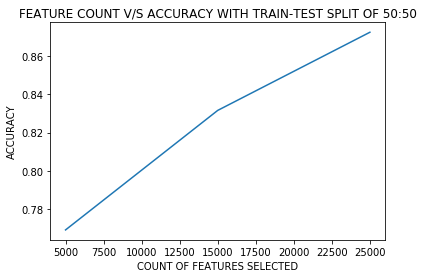

In [318]:
plt.plot(features[0:3],perf[0:3])
plt.xlabel("COUNT OF FEATURES SELECTED")
plt.ylabel("ACCURACY")
plt.title("FEATURE COUNT V/S ACCURACY WITH TRAIN-TEST SPLIT OF 50:50")
plt.show()

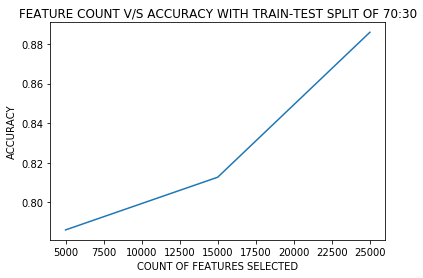

In [319]:
plt.plot(features[3:6],perf[3:6])
plt.xlabel("COUNT OF FEATURES SELECTED")
plt.ylabel("ACCURACY")
plt.title("FEATURE COUNT V/S ACCURACY WITH TRAIN-TEST SPLIT OF 70:30")
plt.show()

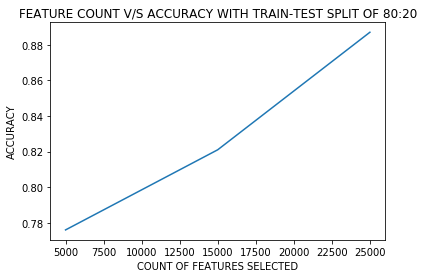

In [320]:
plt.plot(features[6:9],perf[6:9])
plt.xlabel("COUNT OF FEATURES SELECTED")
plt.ylabel("ACCURACY")
plt.title("FEATURE COUNT V/S ACCURACY WITH TRAIN-TEST SPLIT OF 80:20")
plt.show()

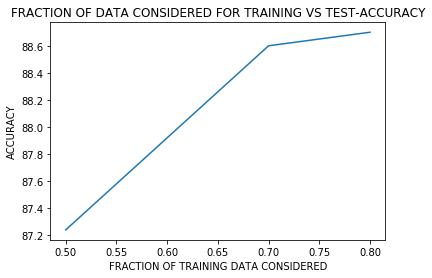

In [321]:
plt.plot([train_size[2],train_size[5],train_size[8]],[perf[2]*100,perf[5]*100,perf[8]*100])
plt.xlabel("FRACTION OF TRAINING DATA CONSIDERED")
plt.ylabel("ACCURACY")
plt.title("FRACTION OF DATA CONSIDERED FOR TRAINING VS TEST-ACCURACY")
plt.show()